In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# NLTK and TextBlob for NLP and Sentiment Analysis
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob

# Download NLTK data (run once)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except nltk.downloader.DownloadError:
    nltk.download('averaged_perceptron_tagger')

print("Libraries and NLTK data loaded successfully.")

Libraries and NLTK data loaded successfully.


In [10]:
# Assuming your data folder is relative to the notebook, e.g., ../data/raw_analyst_ratings.csv
news_filepath = '../data/raw_analyst_ratings.csv'

# Use the data_loader function if you have it, otherwise load directly
# from src.news_processor import load_financial_news_data
# df_news = load_financial_news_data(filepath=news_filepath)

try:
    df_news = pd.read_csv(news_filepath)
    print(f"Original news data loaded from {news_filepath}")
    print(f"Shape: {df_news.shape}")

    # Initial date processing (similar to what news_processor.py would do)
    if 'date' in df_news.columns:
        df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')
        # Create a 'publication_day' column for daily aggregation later
        df_news['publication_day'] = df_news['date'].dt.normalize()
        print("Date column processed and 'publication_day' created.")
    else:
        print("Warning: 'date' column not found in news data.")

except FileNotFoundError:
    print(f"Error: News data file not found at {news_filepath}. Please ensure the file exists.")
    df_news = pd.DataFrame() # Create an empty DataFrame to prevent errors later
except Exception as e:
    print(f"An unexpected error occurred while loading news data: {e}")
    df_news = pd.DataFrame()

if not df_news.empty:
    print("\nFirst 5 rows of news data:")
    print(df_news.head())
    print("\nInfo on news data:")
    df_news.info()

Original news data loaded from ../data/raw_analyst_ratings.csv
Shape: (1407328, 6)
Date column processed and 'publication_day' created.

First 5 rows of news data:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...


Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


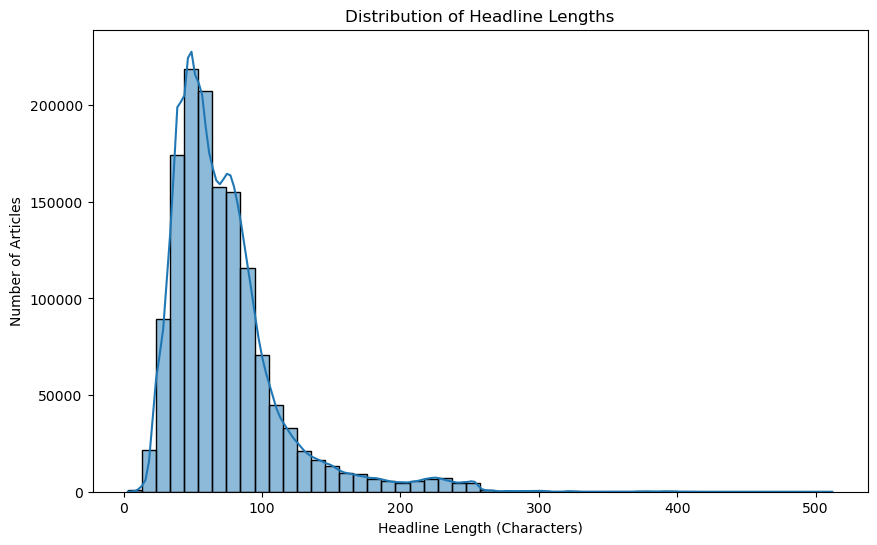

In [11]:
if not df_news.empty and 'headline' in df_news.columns:
    df_news['headline_length'] = df_news['headline'].apply(len)
    print("\nHeadline Length Statistics:")
    print(df_news['headline_length'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(df_news['headline_length'], bins=50, kde=True)
    plt.title('Distribution of Headline Lengths')
    plt.xlabel('Headline Length (Characters)')
    plt.ylabel('Number of Articles')
    plt.show()
else:
    print("Skipping headline length analysis: 'headline' column missing or df_news is empty.")


Top 10 Publishers by Article Count:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


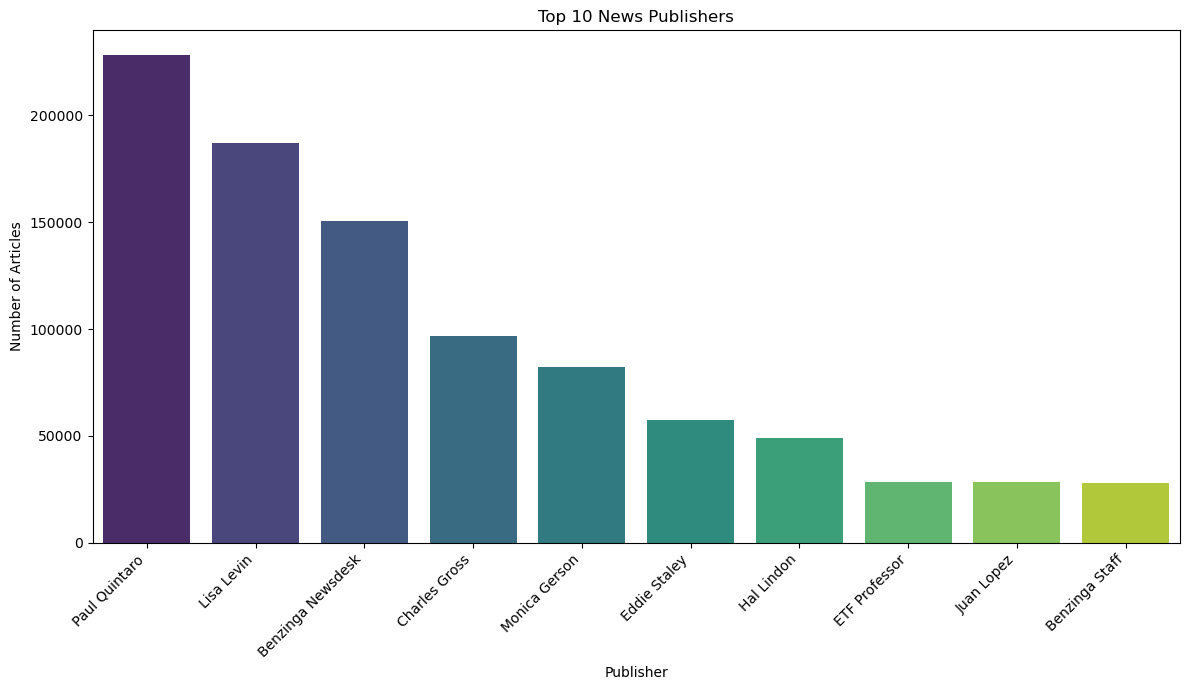

In [12]:
if not df_news.empty and 'publisher' in df_news.columns:
    publisher_counts = df_news['publisher'].value_counts().head(10)
    print("\nTop 10 Publishers by Article Count:")
    print(publisher_counts)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=publisher_counts.index, y=publisher_counts.values, palette='viridis')
    plt.title('Top 10 News Publishers')
    plt.xlabel('Publisher')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping publisher analysis: 'publisher' column missing or df_news is empty.")


Daily News Publication Counts (Head):
publication_day
2011-04-27 00:00:00-04:00    1
2011-04-28 00:00:00-04:00    2
2011-04-29 00:00:00-04:00    2
2011-04-30 00:00:00-04:00    1
2011-05-01 00:00:00-04:00    1
Name: count, dtype: int64


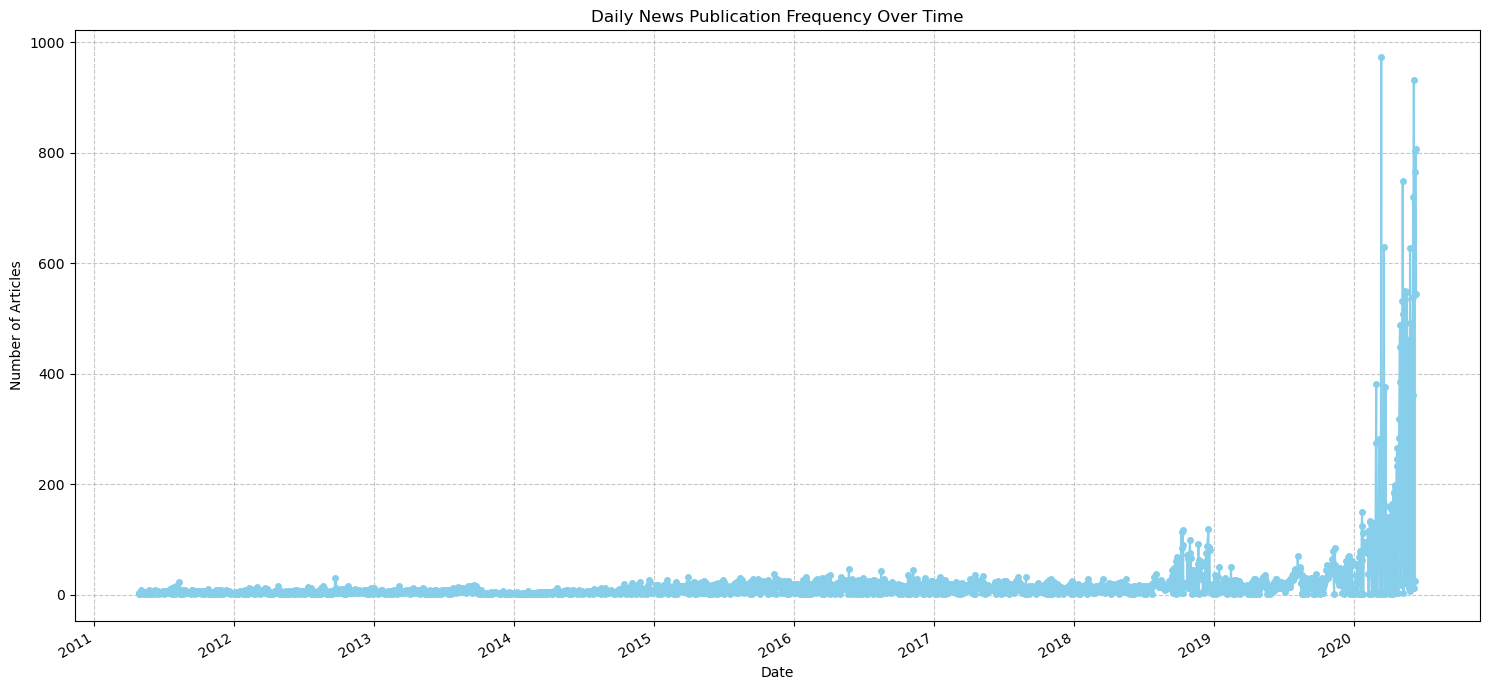

In [13]:
if not df_news.empty and 'publication_day' in df_news.columns:
    daily_news_counts = df_news['publication_day'].value_counts().sort_index()
    print("\nDaily News Publication Counts (Head):")
    print(daily_news_counts.head())

    plt.figure(figsize=(15, 7))
    daily_news_counts.plot(kind='line', marker='o', linestyle='-', color='skyblue', markersize=4)
    plt.title('Daily News Publication Frequency Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping daily news frequency analysis: 'publication_day' column missing or df_news is empty.")

In [14]:
def preprocess_text(text):
    if not isinstance(text, str):
        return "" # Return empty string for non-string input (e.g., NaN)

    # 1. Lowercasing
    text = text.lower()

    # 2. Remove punctuation
    text = re.sub(r'[^\w\s]', '', text) # Keeps only alphanumeric and whitespace

    # 3. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 4. Tokenization
    tokens = word_tokenize(text)

    # 5. Remove stopwords and lemmatization
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    cleaned_tokens = []
    for token in tokens:
        if token not in stop_words:
            cleaned_tokens.append(lemmatizer.lemmatize(token))

    return ' '.join(cleaned_tokens)

import re # Make sure re is imported if not already in Cell 1

if not df_news.empty and 'headline' in df_news.columns:
    print("\nApplying text preprocessing to headlines...")
    df_news['processed_headline'] = df_news['headline'].apply(preprocess_text)
    print("Text preprocessing complete. Sample processed headlines:")
    print(df_news[['headline', 'processed_headline']].head())
else:
    print("Skipping text preprocessing: 'headline' column missing or df_news is empty.")


Applying text preprocessing to headlines...
Text preprocessing complete. Sample processed headlines:
                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                  processed_headline  
0                         stock hit week high friday  
1                      stock hit week high wednesday  
2                               biggest mover friday  
3                 stock moving friday midday session  
4  b security maintains neutral agilent technolog...  



Calculating sentiment scores...
Sentiment analysis complete. Sample headlines with scores:
                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                  processed_headline  sentiment_score  
0                         stock hit week high friday             0.16  
1                      stock hit week high wednesday             0.16  
2                               biggest mover friday             0.00  
3                 stock moving friday midday session             0.00  
4  b security maintains neutral agilent technolog...             0.00  

Sentiment Score Distribution:
count    1.407328e+06
mean     5.305259e-02
std      1.844343e-01
min     -1.000000e+00
25%      0.000000e+0

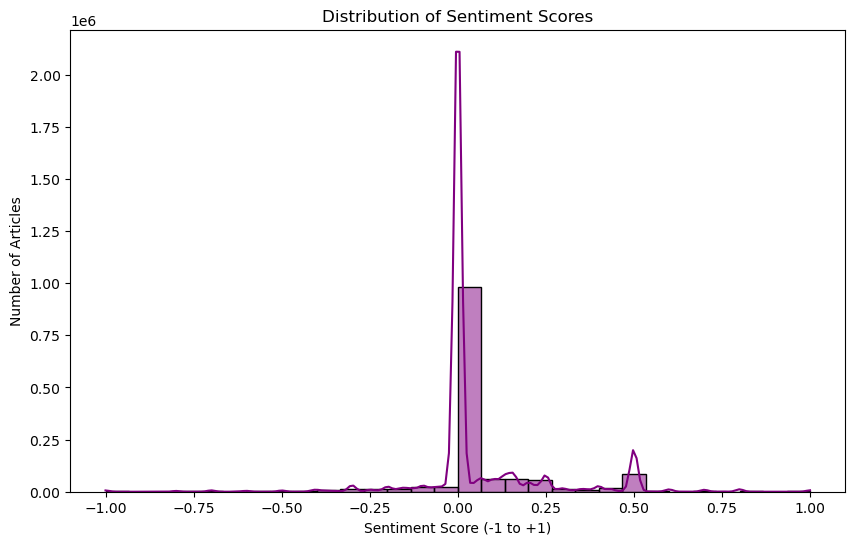

In [19]:
def get_sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity # Polarity ranges from -1 (negative) to +1 (positive)

if not df_news.empty and 'processed_headline' in df_news.columns:
    print("\nCalculating sentiment scores...")
    df_news['sentiment_score'] = df_news['processed_headline'].apply(get_sentiment_score)
    print("Sentiment analysis complete. Sample headlines with scores:")
    print(df_news[['headline', 'processed_headline', 'sentiment_score']].head())

    # Display sentiment distribution
    print("\nSentiment Score Distribution:")
    print(df_news['sentiment_score'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(df_news['sentiment_score'], bins=30, kde=True, color='purple')
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score (-1 to +1)')
    plt.ylabel('Number of Articles')
    plt.show()
else:
    print("Skipping sentiment analysis: 'processed_headline' column missing or df_news is empty.")

In [ ]:
# In eda_and_data_prep.ipynb
if not df_news.empty and 'publication_day' in df_news.columns and 'stock' in df_news.columns and 'sentiment_score' in df_news.columns:
    print("\nAggregating daily average sentiment per stock...")
    daily_avg_sentiment = df_news.groupby(['publication_day', 'stock'])['sentiment_score'].mean().reset_index()

    daily_avg_sentiment.rename(columns={
        'publication_day': 'Date',
        'stock': 'Ticker',  # <--- THIS IS THE CRITICAL RENAME
        'sentiment_score': 'daily_avg_sentiment'
    }, inplace=True)

    daily_avg_sentiment['Date'] = pd.to_datetime(daily_avg_sentiment['Date'])

    print("\nDaily Aggregated Sentiment per Stock (Head):")
    print(daily_avg_sentiment.head()) # <-- Check output here for 'Ticker' column
    print("\nDaily Aggregated Sentiment Info:")
    daily_avg_sentiment.info() # <-- Check output here for 'Ticker' column

In [17]:
if not df_news.empty and 'publication_day' in df_news.columns and 'stock' in df_news.columns and 'sentiment_score' in df_news.columns:
    print("\nAggregating daily average sentiment per stock...")
    # Group by publication day and stock, then calculate the mean sentiment score
    daily_avg_sentiment = df_news.groupby(['publication_day', 'stock'])['sentiment_score'].mean().reset_index()

    # Rename columns for clarity and consistency (e.g., for merging later)
    daily_avg_sentiment.rename(columns={
        'publication_day': 'Date',
        'stock': 'Ticker',
        'sentiment_score': 'daily_avg_sentiment'
    }, inplace=True)

    # Ensure 'Date' column is datetime type for merging
    daily_avg_sentiment['Date'] = pd.to_datetime(daily_avg_sentiment['Date'])

    print("\nDaily Aggregated Sentiment per Stock (Head):")
    print(daily_avg_sentiment.head())
    print("\nDaily Aggregated Sentiment Info:")
    daily_avg_sentiment.info()
else:
    print("Skipping daily sentiment aggregation: Required columns missing or df_news is empty.")


Aggregating daily average sentiment per stock...

Daily Aggregated Sentiment per Stock (Head):
                       Date Ticker  daily_avg_sentiment
0 2011-04-27 00:00:00-04:00    DGP             0.000000
1 2011-04-28 00:00:00-04:00    DEJ             0.000000
2 2011-04-28 00:00:00-04:00    ESR             0.136364
3 2011-04-29 00:00:00-04:00    AIA            -0.166667
4 2011-04-29 00:00:00-04:00    GDL             0.500000

Daily Aggregated Sentiment Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44196 entries, 0 to 44195
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   Date                 44196 non-null  datetime64[ns, UTC-04:00]
 1   Ticker               44196 non-null  object                   
 2   daily_avg_sentiment  44196 non-null  float64                  
dtypes: datetime64[ns, UTC-04:00](1), float64(1), object(1)
memory usage: 1.0+ MB


In [18]:
if not daily_avg_sentiment.empty:
    output_dir = '../data/processed/' # Adjust path as needed
    os.makedirs(output_dir, exist_ok=True) # Create directory if it doesn't exist

    output_filepath = os.path.join(output_dir, 'daily_aggregated_sentiment.csv')
    daily_avg_sentiment.to_csv(output_filepath, index=False) # index=False prevents writing the DataFrame index as a column
    print(f"\nDaily aggregated sentiment data saved to: {output_filepath}")
else:
    print("No daily aggregated sentiment data to save.")


Daily aggregated sentiment data saved to: ../data/processed/daily_aggregated_sentiment.csv
